### Project Description

You've done beautifully in the Practicum course, and you've been offered an internship in the analytical department at Yandex.Afisha. Your first task is to help optimize marketing expenses.
You have:
•	Server logs with data on Yandex.Afisha visits from January 2017 through December 2018
•	Dump file with all orders for the period
•	Marketing expenses statistics

You are going to study:
•	How people use the product
•	When they start to buy
•	How much money each customer brings
•	When they pay off


## Step 1. Download the data and prepare it for analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Download datasets. Store the data on visits, orders, and expenses in variables. 

In [2]:
visits = pd.read_csv('datasets/visits_log_us.csv', 
                     dtype={'Device': 'category'},
                    parse_dates=['Start Ts', 'End Ts'])
#visits.head()

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Uid        358532 non-null  uint64        
 1   Device     358532 non-null  category      
 2   End Ts     358532 non-null  datetime64[ns]
 3   Source Id  358532 non-null  int64         
 4   Start Ts   358532 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [4]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%d.%m.%Y %H:%M')
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format='%d.%m.%Y %H:%M')
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-01-07 01:54:00,5,2017-01-07 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


In [5]:
orders = pd.read_csv('datasets/orders_log_us.csv',
                    parse_dates=['Buy Ts'])
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
costs = pd.read_csv('datasets/costs_us.csv',
                   parse_dates=['dt'])
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [7]:
orders['Buy Ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: Buy Ts, dtype: object

In [8]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

The range of expense dates coincides with that of order dates. This will help to build cohorts later.

### Optimize the data for analysis. Make sure each column contains the correct data type.

In [9]:
visits.info(memory_usage='deep')    #BEFORE OPTIMIZATION - memory usage: 77.0 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Uid        358532 non-null  uint64        
 1   Device     358532 non-null  category      
 2   End Ts     358532 non-null  datetime64[ns]
 3   Source Id  358532 non-null  int64         
 4   Start Ts   358532 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [10]:
orders.info(memory_usage='deep')    #BEFORE OPTIMIZATION - memory usage: 4.4 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [11]:
costs.info(memory_usage='deep')     #BEFORE OPTIMIZATION - memory usage: 206.2 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


#### Conclusion

Very impressive reduction in memory usage, particularly 'object' to 'category'. Parse_dates alone resulted in a 71-72% decrease, parse_dates plus dtype resulted in a 85% memory usage decrease for the 'visits' table.

Data types are correct. 

#### Merging tables. Renaming columns.

In [12]:
def get_info(attr, *dfs):
    return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', visits, orders, costs)

[(358532, 5), (50415, 3), (2542, 3)]

In [13]:
def to_clean(val):
    return val.strip().lower().replace(" ", "_")
visits = visits.rename(columns=to_clean)

 ## Step 2. Make reports and calculate metrics:

#### 1. Product 1. How many people use it every day, week, and month? 2. How many sessions are there per day? (One user might have more than one session.) 3. What is the length of each session? 4. How often do users come back?

#### 1. Number of Active Users by Day, Week and Month

In [14]:
visits['session_start_ts'] = pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M")
visits['session_end_ts'] = pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M")

visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

visits.head()

,uid,device,end_ts,source_id,start_ts,session_start_ts,session_end_ts,session_year,session_month,session_week,session_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-20 17:20:00,2017-12-20 17:38:00,2017,12,51,2017-12-20
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-19 16:53:00,2018-02-19 17:21:00,2018,2,8,2018-02-19
2,7459035603376831527,touch,2017-01-07 01:54:00,5,2017-01-07 01:54:00,2017-01-07 01:54:00,2017-01-07 01:54:00,2017,1,1,2017-01-07
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-20 10:59:00,2018-05-20 11:23:00,2018,5,20,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27 14:06:00,2017,12,52,2017-12-27


In [15]:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean() # you don't need here to group by year
dau_total = visits.groupby(['session_date']).agg({'uid': 'nunique'}).mean() # you don't need here to group by year
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean() # you don't need here to group by year
print('Daily active users =',int(dau_total))
print('Weekly active users =',int(wau_total))
print('Monthly active users =',int(mau_total))

Daily active users = 907
Weekly active users = 4386
Monthly active users = 12300


#### Number of Sessions per User per Month

In [16]:
sessions_per_user = visits.groupby(['session_month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head()

,n_sessions,n_users,sessions_per_user
session_month,,,
1,33311,26523,1.255929
2,31609,25700,1.229922
3,32565,26413,1.232916
4,27630,22842,1.209614
5,30260,24559,1.232135


#### 2. Number of sessions per User per Day

In [17]:
sessions_per_user_date = visits.groupby(['session_date']).agg({'uid': ['count','nunique']})
sessions_per_user_date.columns = ['n_sessions_date', 'n_users_date']
sessions_per_user_date['sessions_per_user_date'] = sessions_per_user_date['n_sessions_date'] / sessions_per_user_date['n_users_date']
sessions_per_user_date.head()

,n_sessions_date,n_users_date,sessions_per_user_date
session_date,,,
2017-01-06,661,605,1.092562
2017-01-07,389,361,1.077562
2017-01-08,437,410,1.065854
2017-01-09,620,572,1.083916
2017-01-10,894,848,1.054245


#### 3. Find the ASL (Average Session Length) 

In [18]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

Average session length is 60 seconds.

#### 4. There's also the sticky factor. This metric tells you how loyal the audience is — how often they return to the app. 

In [19]:
sticky_wau = dau_total/wau_total*100
#print(sticky_wau)
print(int(sticky_wau),'users come back to the app each week.')
sticky_mau = dau_total/mau_total*100
#print(sticky_mau)
print(int(sticky_mau),'users come back to the app each month.')

20 users come back to the app each week.
7 users come back to the app each month.


#### 2.	Sales 1. When do people start buying? 2. How many orders do they make during a given period of time? 3. What is the average purchase size? 4. How much money do they bring? (LTV)

#### 1. When do people start buying? 

In [20]:
orders['first_buy_ts'] = pd.to_datetime(orders['Buy Ts'], format="%Y-%m-%d %H:%M")

orders['first_buy_date'] = orders['first_buy_ts'].dt.date
orders

,Buy Ts,Revenue,Uid,first_buy_ts,first_buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-31


In [21]:
min_order_date = orders.groupby('Uid')['first_buy_date'].min() 
min_order_date

Uid
313578113262317         2018-01-03
1575281904278712        2017-06-03
2429014661409475        2017-10-11
2464366381792757        2018-01-28
2551852515556206        2017-11-24
                           ...    
18445147675727495770    2017-11-24
18445407535914413204    2017-09-22
18445601152732270159    2018-03-26
18446156210226471712    2018-02-18
18446167067214817906    2017-10-17
Name: first_buy_date, Length: 36523, dtype: object

In [22]:
min_order_date.name = 'min_order_date'

In [23]:
orders = orders.join(min_order_date, on='Uid')
orders

,Buy Ts,Revenue,Uid,first_buy_ts,first_buy_date,min_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-31,2018-05-31


In [24]:
min_visit_date = visits.groupby('uid')['session_date'].min() 
min_visit_date

uid
11863502262781          2018-01-03
49537067089222          2018-06-02
297729379853735         2017-07-06
313578113262317         2017-09-18
325320750514679         2017-09-30
                           ...    
18446403737806311543    2017-11-30
18446424184725333426    2017-06-12
18446556406699109058    2018-01-01
18446621818809592527    2017-12-27
18446676030785672386    2017-04-10
Name: session_date, Length: 228169, dtype: object

In [25]:
min_visit_date.name = 'min_visit_date'

In [26]:
visits = visits.join(min_visit_date, on='uid')
visits

,uid,device,end_ts,source_id,start_ts,session_start_ts,session_end_ts,session_year,session_month,session_week,session_date,session_duration_sec,min_visit_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-20 17:20:00,2017-12-20 17:38:00,2017,12,51,2017-12-20,1080,2017-12-20
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-19 16:53:00,2018-02-19 17:21:00,2018,2,8,2018-02-19,1680,2018-02-19
2,7459035603376831527,touch,2017-01-07 01:54:00,5,2017-01-07 01:54:00,2017-01-07 01:54:00,2017-01-07 01:54:00,2017,1,1,2017-01-07,0,2017-01-07
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-20 10:59:00,2018-05-20 11:23:00,2018,5,20,2018-05-20,1440,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27 14:06:00,2017,12,52,2017-12-27,0,2017-12-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358527,272012551460639309,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,2018-03-20 15:11:00,2018-03-20 15:25:00,2018,3,12,2018-03-20,840,2018-03-20
358528,11171727274084046837,touch,2018-05-15 23:09:00,2,2018-05-15 23:08:00,2018-05-15 23:08:00,2018-05-15 23:09:00,2018,5,20,2018-05-15,60,2017-02-10
358529,13482259146982443019,desktop,2018-06-05 20:27:00,5,2018-06-05 20:27:00,2018-06-05 20:27:00,2018-06-05 20:27:00,2018,6,23,2018-06-05,0,2018-04-17
358530,3266363999948772866,touch,2018-03-04 11:23:00,5,2018-03-04 11:19:00,2018-03-04 11:19:00,2018-03-04 11:23:00,2018,3,9,2018-03-04,240,2018-03-04


In [27]:
orders_new = orders.groupby('Uid')['min_order_date'].nunique().reset_index()
#orders_new

In [28]:
visits_new = visits.groupby(['uid'])['min_visit_date'].nunique().reset_index()
#visits_new

In [29]:
purchased = orders_new.merge(visits_new, left_on='Uid', right_on='uid')

In [30]:
purchased['Uid'].nunique()

36523

In [31]:
purchased.drop(purchased.columns[[1,3]], axis=1, inplace=True)

In [32]:
#purchased

In [33]:
purch_date = purchased.join(min_order_date, on='Uid')
#purch_date

In [34]:
vis_date = purchased.join(min_visit_date, on='uid')
#vis_date

In [35]:
days_to_buy = purch_date['min_order_date'] - vis_date['min_visit_date']
days_to_buy.head(10)

0    107 days
1     89 days
2    -30 days
3      1 days
4      0 days
5      0 days
6    195 days
7      0 days
8   -235 days
9      0 days
dtype: timedelta64[ns]

In [36]:
days_to_buy.mean()

Timedelta('36 days 11:05:55.534868')

#### Conclusion: People start to buy 16 days after their first visit on average.

In [37]:
first_order_date_by_customers = orders.groupby('Uid')['Buy Ts'].min() 
#first_order_date_by_customers.head()

In [38]:
first_order_date_by_customers.name = 'first_order_date'

In [39]:
new_orders = orders.join(first_order_date_by_customers,on='Uid') 
new_orders.head()

,Buy Ts,Revenue,Uid,first_buy_ts,first_buy_date,min_order_date,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01 07:58:00


In [40]:
#improve column names
def to_clean(val):
    return val.strip().lower().replace(" ", "_")
new_orders = new_orders.rename(columns=to_clean)

In [41]:
new_orders['first_order_month'] = new_orders['first_order_date'].astype('datetime64[M]')
new_orders['order_month'] = new_orders['buy_ts'].astype('datetime64[M]')
new_orders.head()

,buy_ts,revenue,uid,first_buy_ts,first_buy_date,min_order_date,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01


#### 2. How many orders do they make during a month?

In [42]:
new_orders.pivot_table(index='first_order_month',
                        columns='order_month',
                        values='uid',
                        aggfunc='count') 

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0,NaN
2017-07-01,NaN,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2017-08-01,NaN,NaN,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN
2017-09-01,NaN,NaN,NaN,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,5052.0,270.0,202.0,179.0,86.0,105.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3783.0,224.0,159.0,64.0,78.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4095.0,222.0,83.0,70.0,NaN


The first month of any group is very high, then falls off sharply and remains low but steady. I think this reflects a large number of one time purchases and a small but steady number of loyal customers. 

#### 3. Average purchase size

In [43]:
cohort_grouped_avg = new_orders.groupby('first_order_month').agg({'uid':'nunique','revenue':'mean'})
cohort_grouped_avg  

,uid,revenue
first_order_month,,
2017-06-01,2023,5.414982
2017-07-01,1923,5.542241
2017-08-01,1370,5.304506
2017-09-01,2581,8.941805
2017-10-01,4340,4.596744
2017-11-01,4081,4.423558
2017-12-01,4383,5.681327
2018-01-01,3373,3.867950
2018-02-01,3651,3.747315


#### 4. How much money did they bring? (LTV calculated later)

In [44]:
cohort_grouped = new_orders.groupby('first_order_month').agg({'uid':'nunique','revenue':'sum'})
cohort_grouped

,uid,revenue
first_order_month,,
2017-06-01,2023,24031.69
2017-07-01,1923,16127.92
2017-08-01,1370,11606.26
2017-09-01,2581,34676.32
2017-10-01,4340,27603.45
2017-11-01,4081,26098.99
2017-12-01,4383,33485.74
2018-01-01,3373,16663.13
2018-02-01,3651,16750.50


December had the most users. September was the highest revenue month, followed by December. The holiday period October through December has good revenue. January through May sales slump. June is a good revenue month.

Users were spending more in June and September. Half as many users (June, September) brought in a similar revenue as October, November and December. 


In [45]:
orders_grouped_by_cohorts = new_orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
#orders_grouped_by_cohorts.head()

In [46]:
orders_grouped_by_cohorts['revenue_per_user']=orders_grouped_by_cohorts['revenue']/orders_grouped_by_cohorts['uid']

#### Average revenue per User

In [47]:
orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                      columns='order_month',
                                      values='revenue_per_user',
                                      aggfunc='mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


#### cohort lifetime

In [48]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
#orders_grouped_by_cohorts['cohort_lifetime'].head()

In [49]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
#print(orders_grouped_by_cohorts['cohort_lifetime'].head())

In [50]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
#print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].head())
#print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].tail())

In [51]:
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')

0     01.06.2017
1     01.06.2017
2     01.06.2017
3     01.06.2017
4     01.06.2017
         ...    
74    01.03.2018
75    01.04.2018
76    01.04.2018
77    01.05.2018
78    01.06.2018
Name: first_order_month, Length: 79, dtype: object

In [52]:
orders_grouped_by_cohorts['first_order_month']=orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

#### Average revenue per user, per cohort lifetime

In [53]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')
#print(revenue_per_user_pivot)

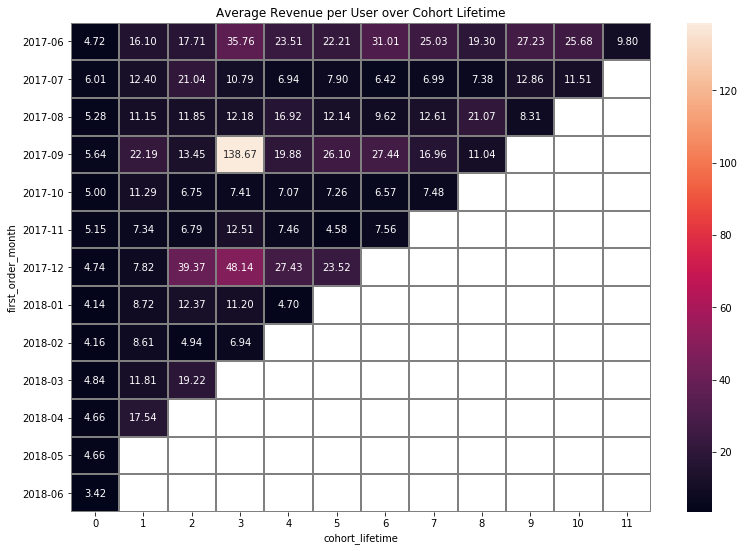

In [54]:
plt.figure(figsize=(13, 9))
plt.title('Average Revenue per User over Cohort Lifetime')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Here we see clearly for which cohorts revenue per user increased in the month following the month of first purchase. For some cohorts, revenue per user increased rapidly over time (for instance, the December 2017 cohorts).

This heatmap shows clearly that September is the highest month. There is also an obvious spike in per user spending in the 4th cohort period.

### Users Lifetime Value (LTV) and Cost of Acquisition (CAC)

In [55]:
#retrieve the month of each customer's first purchase
first_orders = new_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
#first_orders.head()

In [56]:
#calculate the number of new customers (n_buyers) for each month
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [57]:
#group the table of orders by month of first purchase and month of purchase and sum up the revenue
cohorts = new_orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


The row of the cohort table specifies the revenue the cohort brought. For example, from the 0 row we can see that the customers who placed their first order in June 2017 brought in a total revenue of $9557.49 that month.

In [58]:
#LTV is a cohort's cumulative revenue
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [59]:
#staying with the formula, but replaced margin rate as 1
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

#report.head()

#### LTV

In [60]:
#calculate LTV. Divide the cohort's gross profit for each month by the total number of users in each cohort.
report['ltv'] = report['gp'] / report['n_buyers']
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [61]:
output = report.pivot_table(
                            index='first_order_month', 
                            columns='age', 
                            values='ltv', 
                            aggfunc='mean').cumsum(axis=1)

output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


#### Calculating LTV and CAC

In [62]:
# calculating the costs per month
monthly_costs = costs[['dt','costs']].groupby('dt').sum()
#monthly_costs.head()

#### Cost of Acquisition (CAC) 

In [63]:
#add the data on costs to the report and calculate CAC:
report_ = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='dt')
report_['cac'] = report_['costs'] / report_['n_buyers']
report_  

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,735.26,0.363450
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,735.26,0.363450
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,735.26,0.363450
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,735.26,0.363450
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,735.26,0.363450
...,...,...,...,...,...,...,...,...,...
71,2018-02-01,3651,2018-05-01,270.70,270.70,3,0.074144,1378.76,0.377639
72,2018-03-01,3533,2018-03-01,17095.49,17095.49,0,4.838803,1437.28,0.406816
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,1437.28,0.406816
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,1437.28,0.406816


Investment in customer acquisition paid off and even led to profit during the first month. After the first month the cost of acquisition compared to the value of the customer fluctuates, but overall does not look good. A better asessment will be calculating the ROI.

### 3.	Marketing 1. How much money was spent? Overall/per source/over time 2. How much did customer acquisition from each of the sources cost? 3. How worthwhile where the investments? (ROI)

#### Plot graphs to display how these metrics differ for various devices and ad sources and how they change in time.

#### 1a. Marketing money spent overall

In [64]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
#costs_by_source['costs'].sum().round(2)
print('The Marketing money spent overall was',costs_by_source['costs'].sum().round(2))

The Marketing money spent overall was 329131.62


#### 1b. Marketing money spent per source

In [65]:
costs_by_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


The costs are high for source number 3. One would hope there was great revenue for number 3, making the expense worthwhile. Later, we will find out that the revenue is not that great, therefore source 3 is not worth it.

#### 1c. Marketing money spent over time

In [66]:
monthly_costs = costs[['dt','costs']].groupby('dt').sum()
monthly_costs

,costs
dt,
2017-06-01,735.26
2017-06-02,721.19
2017-06-03,450.85
2017-06-04,761.16
2017-06-05,821.44
...,...
2018-05-27,532.87
2018-05-28,619.44
2018-05-29,784.79


#### 2. Cost of CAC from each of the ad sources

In [67]:
unique_visits_with_source = visits[['source_id','uid']].groupby('source_id').agg({'uid': 'nunique'})    
unique_visits_with_source

,uid
source_id,
1,18999
2,26245
3,74756
4,83525
5,56974
6,6
7,34
9,9264
10,8067


In [68]:
cac_per_source = costs_by_source['costs'] / unique_visits_with_source['uid']
cac_per_source

source_id
1     1.096546
2     1.631017
3     1.890439
4     0.731201
5     0.908434
6          NaN
7          NaN
9     0.595584
10    0.721766
dtype: float64

Text(0, 0.5, 'Costs in USD')

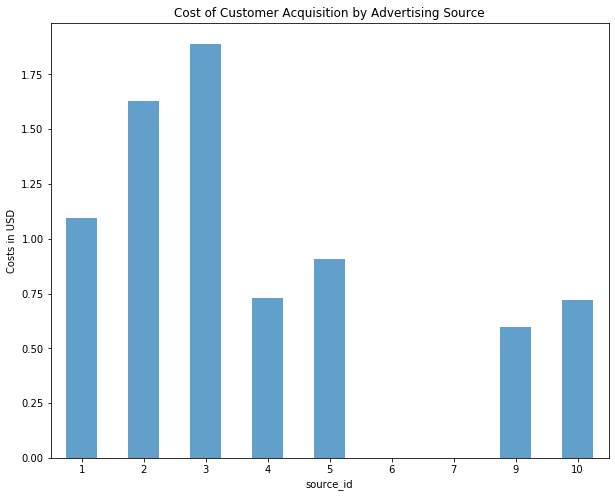

In [69]:
cac_per_source.plot.bar(stacked=False, rot=0, figsize=(10,8),title='Cost of Customer Acquisition by Advertising Source', alpha=0.7)
plt.ylabel('Costs in USD')

#### 3. How worthwhile were the investments (ROI)

In [70]:
#ROMI (return on marketing investment) by dividing LTV by CAC
report_['romi'] = report_['ltv'] / report_['cac']
roi_output = report_.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

roi_output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,13.00,14.33,15.54,18.16,20.98,23.00,25.62,27.22,28.74,30.41,31.98,32.68
2017-07-01,30.57,32.28,35.45,37.28,38.17,38.97,39.58,40.30,41.12,41.87,42.66,NaN
2017-08-01,14.20,15.47,16.71,17.76,19.09,19.85,20.42,21.51,22.30,22.80,NaN,NaN
2017-09-01,27.04,32.39,34.89,53.94,55.86,58.96,62.32,63.48,64.36,NaN,NaN,NaN
2017-10-01,20.94,23.18,23.98,24.64,25.27,25.77,26.13,26.61,NaN,NaN,NaN,NaN
2017-11-01,17.01,18.33,18.99,20.06,20.55,20.73,21.11,NaN,NaN,NaN,NaN,NaN
2017-12-01,19.55,20.63,24.44,28.84,30.13,31.53,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,16.25,17.40,18.60,19.16,19.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,11.01,11.74,11.95,12.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Conclusion: The Return on Marketing Investment is highest in September. Overall the ROI increases each month for each cohort.

#### Revenue and Costs per Advertising Source

In [71]:
#%%time

new_visits = visits.sort_values('session_start_ts').groupby('uid').first()

In [72]:
source_id_per_order = pd.merge(new_visits, orders, left_index=True, right_on='Uid')
source_id_per_order

,device,end_ts,source_id,start_ts,session_start_ts,session_end_ts,session_year,session_month,session_week,session_date,session_duration_sec,min_visit_date,Buy Ts,Revenue,Uid,first_buy_ts,first_buy_date,min_order_date
27944,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18 22:49:00,2017-09-18 23:07:00,2017,9,38,2017-09-18,1080,2017-09-18,2018-01-03 21:51:00,0.55,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01-03
213,touch,2017-03-06 10:17:00,10,2017-03-06 10:13:00,2017-03-06 10:13:00,2017-03-06 10:17:00,2017,3,10,2017-03-06,240,2017-03-06,2017-06-03 10:13:00,1.22,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-03
252,touch,2017-03-06 10:17:00,10,2017-03-06 10:13:00,2017-03-06 10:13:00,2017-03-06 10:17:00,2017,3,10,2017-03-06,240,2017-03-06,2017-06-03 17:39:00,1.83,1575281904278712,2017-06-03 17:39:00,2017-06-03,2017-06-03
12235,desktop,2017-11-10 17:27:00,3,2017-11-10 17:14:00,2017-11-10 17:14:00,2017-11-10 17:27:00,2017,11,45,2017-11-10,780,2017-11-10,2017-10-11 18:33:00,73.33,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-11
31462,desktop,2018-01-27 20:13:00,5,2018-01-27 20:10:00,2018-01-27 20:10:00,2018-01-27 20:13:00,2018,1,4,2018-01-27,180,2018-01-27,2018-01-28 15:54:00,2.44,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,desktop,2017-09-22 23:55:00,3,2017-09-22 23:48:00,2017-09-22 23:48:00,2017-09-22 23:55:00,2017,9,38,2017-09-22,420,2017-09-22,2017-09-24 23:48:00,0.24,18445407535914413204,2017-09-24 23:48:00,2017-09-24,2017-09-22
9023,desktop,2017-09-22 23:55:00,3,2017-09-22 23:48:00,2017-09-22 23:48:00,2017-09-22 23:55:00,2017,9,38,2017-09-22,420,2017-09-22,2017-09-25 15:56:00,0.12,18445407535914413204,2017-09-25 15:56:00,2017-09-25,2017-09-22
42213,desktop,2017-07-08 11:52:00,2,2017-07-08 11:51:00,2017-07-08 11:51:00,2017-07-08 11:52:00,2017,7,27,2017-07-08,60,2017-07-08,2018-03-26 22:54:00,4.22,18445601152732270159,2018-03-26 22:54:00,2018-03-26,2018-03-26
35572,desktop,2017-07-11 10:04:00,3,2017-07-11 10:01:00,2017-07-11 10:01:00,2017-07-11 10:04:00,2017,7,28,2017-07-11,180,2017-07-11,2018-02-18 19:34:00,9.78,18446156210226471712,2018-02-18 19:34:00,2018-02-18,2018-02-18


In [73]:
#making smaller # of columns - row count matches rows in orders
source_id_per_order2 = source_id_per_order[['source_id', 'Revenue', 'Uid']] 
source_id_per_order2

,source_id,Revenue,Uid
27944,2,0.55,313578113262317
213,10,1.22,1575281904278712
252,10,1.83,1575281904278712
12235,3,73.33,2429014661409475
31462,5,2.44,2464366381792757
...,...,...,...
8919,3,0.24,18445407535914413204
9023,3,0.12,18445407535914413204
42213,2,4.22,18445601152732270159
35572,3,9.78,18446156210226471712


In [74]:
source_id_per_order2['Uid'].nunique() #got sum of Uid to make sure of accurate count by source id

36523

In [75]:
revenue_by_source_id = source_id_per_order2.groupby('source_id').agg({'Uid': 'nunique', 'Revenue':'sum'})
#revenue_by_source_id

In [76]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
#costs_by_source

In [77]:
money = pd.merge(revenue_by_source_id, costs_by_source, on='source_id')
money

,Uid,Revenue,costs
source_id,,,
1,2989,33316.97,20833.27
2,3849,64055.41,42806.04
3,10066,49872.84,141321.63
4,10264,53230.65,61073.60
5,6824,40512.36,51757.10
9,1205,6630.29,5517.49
10,1325,4437.46,5822.49


Text(0, 0.5, 'Revenue and Costs in USD')

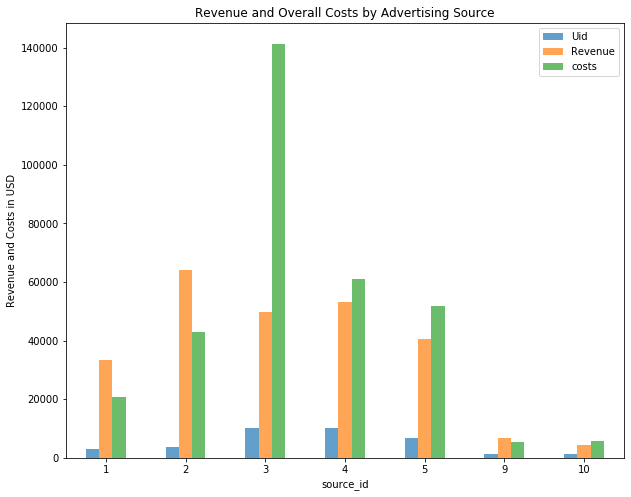

In [78]:
money.plot.bar(stacked=False, rot=0, figsize=(10,8),title='Revenue and Overall Costs by Advertising Source', alpha=0.7)
plt.ylabel('Revenue and Costs in USD')

#### Conclusion: 
Revenue is no longer significantly higher than costs. The ratio of cost to revenue shows Source 1 is the best. Source 2 and 5 are second best performing. Source 5 is reaching more users. Source 3 needs to be removed, it cost more than twice the revenue. Source 6, 7, 8 cost nothing and have no revenue, except $1.22 revenue from one user in Source 7. 

In [79]:
group_by_device = source_id_per_order[['device','Uid']].groupby('device').count()
group_by_device

,Uid
device,
desktop,40921
touch,9494


Text(0, 0.5, 'Number of Users')

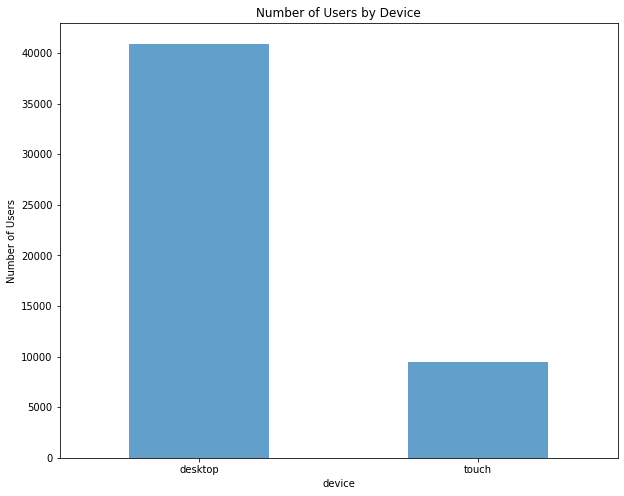

In [80]:
group_by_device.plot.bar(stacked=False, rot=0, figsize=(10,8),title='Number of Users by Device', alpha=0.7, legend=False)
plt.ylabel('Number of Users')

For this data, desktop far outweighs 'touch' devices. There may be additional market share if the 'touch' app is improved. Also, less opportunity for push notifications and impulse purchases on a desktop.

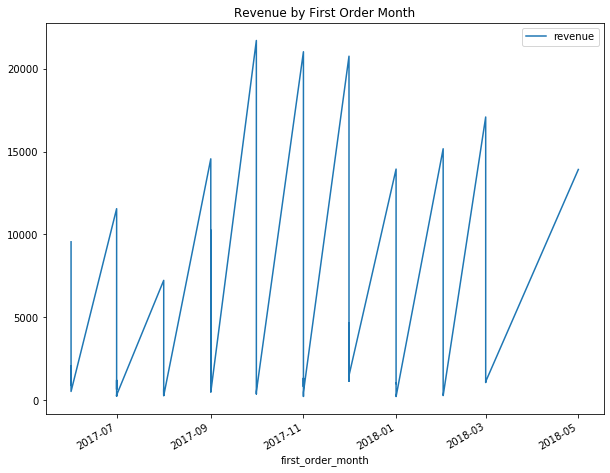

In [81]:
report_.plot.line(y='revenue', x='first_order_month', figsize=(10, 8), title='Revenue by First Order Month')

This graph shows that for each new cohort, the first order month is very large, then drops considerably. There may be users who spend once and do not come back. The heatmap of Revenue per User is consistent with the bottom points in this line chart.

### Step 3. Write a conclusion: advise marketing experts how much money to invest and where.
What sources/platforms would you recommend? Back up your choice: what metrics did you focus on? Why? What conclusions did you draw after finding the metric values?


I recommend Ad Source 1 for the greatest revenue per cost. Find out why Ad Source 3 is so expensive with such a small return. I recommend continuing spending primarily on desktop devices, and investigate why touch screens are so low. There may be additional market share if the 'touch' app is improved.

The first month purchases of any group is very high, then falls off sharply and remains low but steady. I think this reflects a large number of one time purchases and a small but steady number of loyal customers. The ROI increases each month for each loyal customer. I recommend pursuing some type of customer loyalty program targeted at the one time buyers.